https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_inferenece_script_mode.ipynb

In [5]:

%%time

import io
import os
import boto3
import sagemaker
import time

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-xgboost-dist-script"

CPU times: user 49.7 ms, sys: 6.07 ms, total: 55.7 ms
Wall time: 117 ms


In [ ]:
%%time
s3 = boto3.client("s3")
# Load the dataset
FILE_DATA = "abalone2"
s3.download_file(
    "sagemaker-sample-files", f"datasets/tabular/uci_abalone/abalone.libsvm", FILE_DATA
)
sagemaker.Session().upload_data(FILE_DATA, bucket=bucket, key_prefix=prefix + "/train")

In [7]:
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

job_name = "DEMO-xgboost-inference-script-mode-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Training job", job_name)

hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "reg:squarederror",
    "num_round": "50",
    "verbosity": "2",
}

instance_type = "ml.c5.xlarge"

xgb_script_mode_estimator = XGBoost(
    entry_point="abalone.py",
    hyperparameters=hyperparameters,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    framework_version="1.3-1",
    output_path="s3://{}/{}/{}/output".format(bucket, prefix, job_name),
)

content_type = "text/libsvm"
train_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type
)

Training job DEMO-xgboost-inference-script-mode-2022-01-20-10-25-25


In [ ]:
xgb_script_mode_estimator.fit({"train": train_input, "validation": train_input}, job_name=job_name)


In [ ]:
%%writefile abalone_inference.py
import json
import os
import pickle as pkl

import numpy as np

import sagemaker_xgboost_container.encoder as xgb_encoders


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    model_file = "xgboost-model"
    booster = pkl.load(open(os.path.join(model_dir, model_file), "rb"))
    return booster


def input_fn(request_body, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.

    Return a DMatrix (an object that can be passed to predict_fn).
    """
    if request_content_type == "text/libsvm":
        return xgb_encoders.libsvm_to_dmatrix(request_body)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )


def predict_fn(input_data, model):
    """
    SageMaker XGBoost model server invokes `predict_fn` on the return value of `input_fn`.

    Return a two-dimensional NumPy array where the first columns are predictions
    and the remaining columns are the feature contributions (SHAP values) for that prediction.
    """
    prediction = model.predict(input_data)
    feature_contribs = model.predict(input_data, pred_contribs=True, validate_features=False)
    output = np.hstack((prediction[:, np.newaxis], feature_contribs))
    return output


def output_fn(predictions, content_type):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    if content_type == "text/csv":
        return ','.join(str(x) for x in predictions[0])
    else:
        raise ValueError("Content type {} is not supported.".format(content_type))


In [31]:
%%writefile abalone_inference.py

# same with above. 
import json
import os
import pickle as pkl

import numpy as np

import sagemaker_xgboost_container.encoder as xgb_encoders

def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    model_file = "xgboost-model"
    booster = pkl.load(open(os.path.join(model_dir, model_file), "rb"))
    return booster

# input_fn, predict_fn, output_fn대신에, transform_fn을 사용해도 됨.
# content_type : request data's content type
# accept_type : response data's content type
# model : model from model_fn
def transform_fn(model, request_body, content_type, accept_type):
    dmatrix = xgb_encoders.libsvm_to_dmatrix(request_body)
    prediction = model.predict(dmatrix)
    feature_contribs = model.predict(dmatrix, pred_contribs=True, validate_features=False)
    output = np.hstack((prediction[:, np.newaxis], feature_contribs))
    return ','.join(str(x) for x in output[0])

Overwriting abalone_inference.py


In [ ]:
from sagemaker.xgboost.model import XGBoostModel

model_data = xgb_script_mode_estimator.model_data
dependencies = ["inference"]  # inference 폴더의 코드 파일을 entry_point실행코드에서 사용 할 수 있는듯.

print(model_data)
# s3://{bucket}/{prefix}/DEMO-xgboost-inference-script-mode-2022-01-20-10-25-25/output/DEMO-xgboost-inference-script-mode-2022-01-20-10-25-25/output/model.tar.gz
xgb_inference_model = XGBoostModel(
    model_data=model_data,
    role=role,
    entry_point="abalone_inference.py",
    dependencies=dependencies,
    framework_version="1.3-1",
)

In [34]:
predictor = xgb_inference_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge",
)
# 에러시, Cloud watch 로그 확인

-----------!

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_feature_contributions(prediction):

    attribute_names = [
        "Sex",  # nominal / -- / M, F, and I (infant)
        "Length",  # continuous / mm / Longest shell measurement
        "Diameter",  # continuous / mm / perpendicular to length
        "Height",  # continuous / mm / with meat in shell
        "Whole weight",  # continuous / grams / whole abalone
        "Shucked weight",  # continuous / grams / weight of meat
        "Viscera weight",  # continuous / grams / gut weight (after bleeding)
        "Shell weight",  # continuous / grams / after being dried
    ]

    prediction, _, *shap_values, bias = prediction

    if len(shap_values) != len(attribute_names):
        raise ValueError("Length mismatch between shap values and attribute names.")

    df = pd.DataFrame(data=[shap_values], index=["SHAP"], columns=attribute_names).T
    df.sort_values(by="SHAP", inplace=True)

    df["bar_start"] = bias + df.SHAP.cumsum().shift().fillna(0.0)
    df["bar_end"] = df.bar_start + df.SHAP
    df[["bar_start", "bar_end"]] = np.sort(df[["bar_start", "bar_end"]].values)
    df["hue"] = df.SHAP.apply(lambda x: 0 if x > 0 else 1)

    sns.set(style="white")

    ax1 = sns.barplot(x=df.bar_end, y=df.index, data=df, orient="h", palette="vlag")
    for idx, patch in enumerate(ax1.patches):
        x_val = patch.get_x() + patch.get_width() + 0.8
        y_val = patch.get_y() + patch.get_height() / 2
        shap_value = df.SHAP.values[idx]
        value = "{0}{1:.2f}".format("+" if shap_value > 0 else "-", shap_value)
        ax1.annotate(value, (x_val, y_val), ha="right", va="center")

    ax2 = sns.barplot(x=df.bar_start, y=df.index, data=df, orient="h", color="#FFFFFF")
    ax2.set_xlim(
        df[["bar_start", "bar_end"]].values.min() - 1, df[["bar_start", "bar_end"]].values.max() + 1
    )
    ax2.axvline(x=bias, color="#000000", alpha=0.2, linestyle="--", linewidth=1)
    ax2.set_title("base value: {0:.1f}  →  model output: {1:.1f}".format(bias, prediction))
    ax2.set_xlabel("Abalone age")

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.show()


def predict(predictor, libsvm_str):
    label, *features = libsvm_str.strip().split()
    return predictor.predict(" ".join(["-99"] + features))  # use dummy label -99

def predict_and_plot(predictor, libsvm_str):
    predictions = predict(predictor, libsvm_str)
    np_array = np.array([float(x) for x in predictions[0]])
    plot_feature_contributions(np_array)

In [37]:
a_young_abalone = "6 1:3 2:0.37 3:0.29 4:0.095 5:0.249 6:0.1045 7:0.058 8:0.067"
predict(predictor, a_young_abalone)

[['6.8677483',
  '0.0',
  '-0.30064666',
  '-0.24506651',
  '-0.0022994853',
  '-0.27728304',
  '-0.9549683',
  '1.4780574',
  '0.18853942',
  '-2.94223',
  '9.923646']]

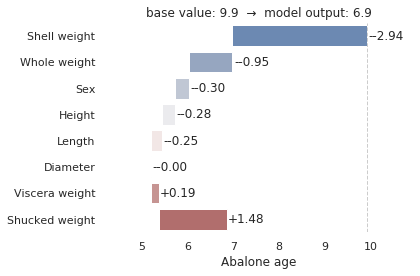

In [38]:

predict_and_plot(predictor, a_young_abalone)

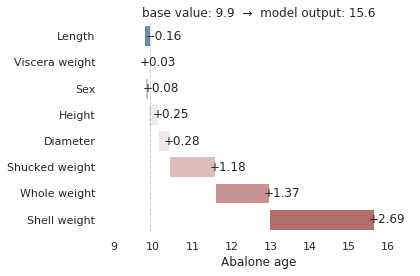

In [39]:
an_old_abalone = "15 1:1 2:0.655 3:0.53 4:0.175 5:1.2635 6:0.486 7:0.2635 8:0.415"
predict_and_plot(predictor, an_old_abalone)

In [41]:

predictor.delete_endpoint()